In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [6]:
import os,sys
sys.path.append('./misc/lib/python3.7/site-packages')

import math
import numpy as np
import requests
import nglview as nv
import ipywidgets as widgets
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import display, display_markdown
from ipywidgets import Layout
from pathlib import Path

import parmed as pmd
import re

import hublib.use
from hublib.ui import FileUpload, Download
from hublib.cmd import runCommand

from scipy.ndimage import gaussian_filter

%use gromacs-5.1.4
%use pymol-1.8.4

np.set_printoptions(precision=8)
np.set_printoptions(suppress=True)

<IPython.core.display.Javascript object>


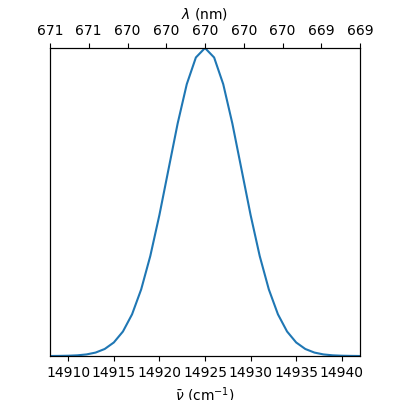

All frequencies are in cm$^{-1}$.

In [22]:
#################################################################
# Model load dialogue
#################################################################

param_drop = widgets.Dropdown(
    options=[],
    description='',
    disabled=False,
    layout = Layout(width='5cm')
)

refresh_button = widgets.Button(
    description='Refresh List',
    layout=Layout(width='2.5cm')
)

load_button = widgets.Button(
    description='Load Model',
    layout=Layout(width='2.5cm')
)


def refresh_onclick(b):
    out = !{'ls params/*_names.txt'}
    prefList = []
    for line in out:
        if line[-4:]=='.txt':
            prefList.append('_'.join(line.split('_')[0:-1]).split('/')[-1])
    param_drop.options = prefList
    if len(prefList)>0:
        param_drop.value = prefList[0]

refresh_button.on_click(refresh_onclick)

def load_button_onclick(b):
    global Coups
    global Freqs
    global Dips
    global Names
    global ParamBox
    global FreqBoxList
    global ParamBoxList
    global FWHMBoxList
    
    # If no parameter files are available, abort
    if len(param_drop.options)==0:
        return 0
    
    prefix = param_drop.value
    
    Coups = np.loadtxt('params/' + prefix + '_coups.txt')
    Freqs = np.loadtxt('params/' + prefix + '_freqs.txt')
    Dips = np.loadtxt('params/' + prefix + '_dips.txt')
    with open('params/' + prefix + '_names.txt') as file:
        NameString = file.readline()
    Names = []
    for name in NameString.strip().split(" "):
        Names.append(name)
        
    # Reshape all variables. This ensures that the data types
    # are treated consistently, even if only a single oscillator
    # is present. 
    Nsites = len(Names)
    Coups.shape = (Nsites,Nsites)
    Freqs.shape = (Nsites,)
    Dips.shape = (Nsites,3)
        
    LblList = []
    FreqBoxList = []
    FWHMBoxList = []
    ParamBoxList = []
    for n in range(0, len(Freqs)):
        LblList.append(widgets.Label(value=Names[n], layout=Layout(width='2cm')))
        
        FreqBoxList.append(
            widgets.FloatText(
                value=Freqs[n],
                disabled=False,
                layout=Layout(width='2.1cm')
            ))

        FWHMBoxList.append(widgets.FloatText(
                value=0.0,
                width='1cm',
                disabled=False, 
                layout=Layout(width='1.6cm')
            ))
    
    for n in range(0, len(Freqs)):
        ParamBoxList.append(widgets.HBox([LblList[n], FreqBoxList[n], FWHMBoxList[n]]))
    ParamBox.children = [DisorderBox,HeadBox] + ParamBoxList
load_button.on_click(load_button_onclick)

refresh_onclick(0)
Coups = []
Freqs = []
Dips = []
Names = []

display(widgets.HBox([load_button, param_drop, refresh_button]))

#################################################################
# Spectrum window setup
#################################################################


def format_coord(x, y):
    #return 'x=%.1f, y=%1.2f'%(x, y)
    return ''


def build_axes():
    specax.set_yticks([])
    specax.set_xlabel('$\\bar\\nu$ (cm$^{-1}$)')
    specax2.xaxis.tick_top()
    specax2.set_xlabel('$\\lambda$ (nm)')
    specax2.format_coord = format_coord
    update_ax2()
    plt.show()

def update_ax2():
    specax2.set_xlim(specax.get_xlim())
    xticks2 = (1.0e7)/(specax.get_xticks())
    
    dlambda = -np.mean(np.diff(xticks2))
    ndec = max(-int(np.ceil(np.log10(dlambda))), 0)
    fmt = "{:." + str(ndec) + "f}"
    xticklabels2 = []
    for tick in xticks2:
        xticklabels2.append(fmt.format(tick))
    
    specax2.set_xticks((1.0e7)/xticks2)
    specax2.set_xticklabels(xticklabels2)
    
    
def update_spec_lims():
    
    lines = [abs_line]
    myinf = 1e+100
    mny = myinf
    mxy = -myinf
    for line in lines:
        if line.get_visible()==True:
            mny = min(mny, np.min(line.get_ydata()))
            mxy = max(mxy, np.max(line.get_ydata()))
    if (mny<myinf) and (mxy>-myinf) and (mny!=mxy):
        specax.set_ylim(mny, mxy)
        
    mnx = len(vaxis) - 1
    mxx = 0
    cutoff = 1e-6
    for line in lines:
        if line.get_visible()==True:
            ndcs = np.where(np.abs(line.get_ydata())>cutoff)[0]
            if len(ndcs>0):
                mnx = min(mnx, np.min(ndcs-1))
                mxx = max(mxx, np.max(ndcs+1))
    if mxx>mnx:
        specax.set_xlim(vaxis[mnx], vaxis[mxx])
        update_ax2()

        
vaxis = np.arange(10000, 18000)

%matplotlib notebook
plt.figure(figsize=(4,4))
specax = plt.gca()
specax2 = specax.twiny()
abs_line, = specax.plot(vaxis, 0.0*vaxis)




#################################################################
# Spectrum calculation setup
#################################################################


def calculate_spec(b):
    global Freqs
    global progress_bar
    
    Nsites = len(Freqs)
    
    for n in range(0, Nsites):
        Freqs[n] = FreqBoxList[n].value
    
    Sigmas = np.zeros((Nsites,))
    if disorder_cb.value==True:
        Nreps = Nits
        for n in range(0, Nsites):
            Sigmas[n] = FWHMBoxList[n].value/2.355
    else:
        Nreps = 1
    
    Ham0 = Coups + np.diag(Freqs)
    
    progress_bar.max = Nreps
    abs_spec = np.zeros(np.shape(vaxis))
    for n in range(0, Nreps):
        dfvec = np.zeros((Nsites,))
        for p in range(0, Nsites):
            dfvec[p] = np.random.normal(0, Sigmas[p])
            
        Ham = Ham0 + np.diag(dfvec)
        eVals,eVecs = np.linalg.eigh(Ham)
        eMu = np.matmul(np.transpose(eVecs), Dips)

        for p in range(0,Nsites):
            ndx = np.where(np.abs(vaxis-eVals[p])==np.min(np.abs(vaxis-eVals[p])))[0][0]
            abs_spec[ndx] += np.linalg.norm(eMu[p])**2/Nsites #mu is a 3 element vector
        progress_bar.value = n + 1
        
    abs_spec = gaussian_filter(abs_spec, sigma=4)
    abs_line.set_ydata(abs_spec)
    
    #np.savetxt('misc/abs.txt', np.array([vaxis, abs_spec/np.max(abs_spec)]).T)
    #disptext = 'Spectrum written to file <a href=\"misc/abs.txt\" target="_blank">abs.txt</a>'
#     display_markdown(disptext, raw=True)
    
    update_spec_lims()
    


HeadBox = widgets.HBox([
    widgets.Label(value="Pigment:", layout=Layout(width='2cm')),
    widgets.Label(value="Frequency:", layout=Layout(width='2cm')),
    widgets.Label(value="FWHM:", layout=Layout(width='1.6cm'))])

calc_button = widgets.Button(
    description='Calculate',
    disabled=False,
    tooltip='Click to calculate spectra',
    #icon='check' # (FontAwesome names without the `fa-` prefix)
)

calc_button.on_click(calculate_spec)

progress_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=1,
    step=1,
    description='',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)

# nit_slider = widgets.IntSlider(
#     value=1,
#     min=1,
#     max=100000,
#     step=1,
#     description='Iterations:',
#     disabled=True,
#     continuous_update=False,
#     orientation='horizontal',
#     readout=True,
#     readout_format='d'
# )

nit_slider = widgets.FloatLogSlider(
    value=0,
    base=10,
    min=0, # max exponent of base
    max=5, # min exponent of base
    step=1, # exponent step
    description='Iterations',
    disabled=True,
    readout_format='d',
)

Nits = nit_slider.value
def nit_on_change(v):
    global Nits
    Nits = int(round(v['new']))
nit_slider.observe(nit_on_change, names='value')

disorder_cb = widgets.Checkbox(
    value=False,
    description='Disorder?',
    disabled=False,
    layout=Layout(width='5cm')
)

def dis_cb_onclick(b):
    nit_slider.disabled = (not disorder_cb.value)
disorder_cb.observe(dis_cb_onclick)

LblList = []
FreqBoxList = []
FWHMBoxList = []
ParamBoxList = []

DisorderBox = widgets.HBox([disorder_cb, nit_slider])

ParamBox = widgets.VBox([DisorderBox,HeadBox] + ParamBoxList)
display(widgets.HBox([calc_button, progress_bar]))
display(ParamBox)
display_markdown('All frequencies are in cm$^{-1}$.', raw=True)
build_axes()
